## YZM304 Second Homework

## Imports and loading data

In [ ]:
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision as tv
import torchvision.datasets as datasets
import torchvision.transforms as T
import torch.nn.functional as F
from torchsummary import summary
import random
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"On device : {device}")

On device : cuda


In [ ]:
bs = 128
num_workers = os.cpu_count() // 2

# 0.1307 and 0.3081 is known normalization values for MNIST
transform = T.Compose([T.Resize((32,32)), T.ToTensor(), T.Normalize((0.1307,), (0.3081,))])

trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=bs, shuffle=True, num_workers=num_workers)
testloader = torch.utils.data.DataLoader(testset, batch_size=bs, shuffle=False, num_workers=num_workers)

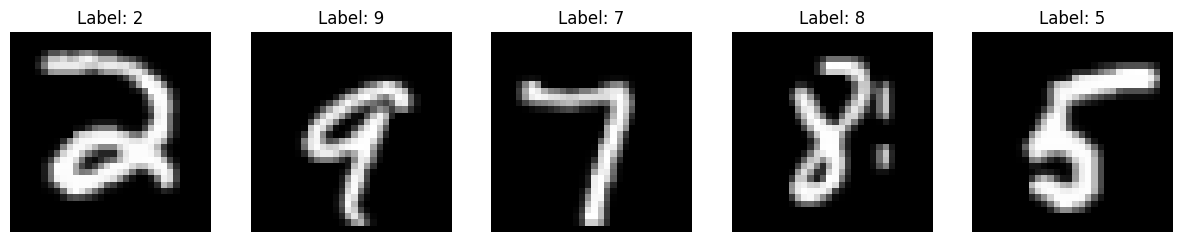

In [3]:
data_iter = iter(trainloader)
images, labels = next(data_iter)

# plot the first 5 images
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    img = images[i]
    # if image is a tensor, convert to numpy and transpose if needed
    if hasattr(img, 'numpy'):
        img = img.numpy()
    if img.shape[0] == 1:  # grayscale
        img = img.squeeze(0)
        axes[i].imshow(img, cmap='gray')
    else:  # color
        axes[i].imshow(img.transpose(1, 2, 0))
    axes[i].set_title(f"Label: {labels[i]}")
    axes[i].axis('off')
plt.show()

## LeNet5 Model

In [5]:
## LeNet5 Model

class LeNet5(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2, stride=2),

        nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2, stride=2),

        nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
        nn.Tanh()
        )
    self.fc = nn.Sequential(
        nn.Linear(120, 84),
        nn.Tanh(),
        nn.Linear(84, 10),
    )

  def forward(self, x):
    x = self.layer1(x)
    x = torch.flatten(x, 1)
    x = self.fc(x)
    x = F.softmax(x, dim=0)
    return x

model = LeNet5().to(device)

# summary of the model
print(summary(model, input_size=(1, 32, 32)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
              Tanh-2            [-1, 6, 28, 28]               0
         AvgPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 10, 10]           2,416
              Tanh-5           [-1, 16, 10, 10]               0
         AvgPool2d-6             [-1, 16, 5, 5]               0
            Conv2d-7            [-1, 120, 1, 1]          48,120
              Tanh-8            [-1, 120, 1, 1]               0
            Linear-9                   [-1, 84]          10,164
             Tanh-10                   [-1, 84]               0
           Linear-11                   [-1, 10]             850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

## Training Loop Function

In [10]:
def set_seed(seed=42): # for reproducibility
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

def train_model(model, trainloader, testloader, criterion, optimizer, scheduler=None, num_epochs=10, device='cuda', seed=42):
    set_seed(seed)
    scaler = torch.cuda.amp.GradScaler() if device == 'cuda' else None # for mixed precision training.
    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        train_loss_sum = 0.0

        for i, (imgs, lbls) in enumerate(trainloader):
            imgs, lbls = imgs.to(device), lbls.to(device)
            optimizer.zero_grad()

            # mixed precision training
            if scaler is not None:
                with torch.cuda.amp.autocast():
                    outputs = model(imgs)
                    loss = criterion(outputs, lbls)
                train_loss_sum += loss.item()
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = model(imgs)
                loss = criterion(outputs, lbls)
                train_loss_sum += loss.item()
                loss.backward()
                optimizer.step()

            if (i+1) % 400 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}'
                      .format(epoch+1, num_epochs, i+1, len(trainloader), loss.item()))

        train_loss_avg = train_loss_sum / len(trainloader)
        train_losses.append(train_loss_avg)

        model.eval()
        total_val_loss = 0
        correct = 0
        total = 0

        with torch.inference_mode():
            for val_imgs, val_lbls in testloader:
                val_imgs, val_lbls = val_imgs.to(device), val_lbls.to(device)
                val_outputs = model(val_imgs)
                val_loss = criterion(val_outputs, val_lbls)
                total_val_loss += val_loss.item()

                _, predicted = val_outputs.max(1)
                total += val_lbls.size(0)
                correct += predicted.eq(val_lbls).sum().item()

        val_accuracy = 100 * correct / total
        avg_val_loss = total_val_loss / len(testloader)
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        print('Validation - Epoch [{}/{}], Test Loss: {:.4f}, Test Accuracy: {:.2f}%'
              .format(epoch+1, num_epochs, avg_val_loss, val_accuracy))

        print('Epoch [{}/{}], Average Train Loss: {:.4f}'
              .format(epoch+1, num_epochs, train_loss_avg))

        if scheduler is not None:
            scheduler.step()
            current_lr = optimizer.param_groups[0]['lr']
            print(f'Learning rate adjusted to: {current_lr:.6f}')

    return train_losses, val_losses, val_accuracies

## Training LeNet5

In [11]:
from torch.optim.lr_scheduler import OneCycleLR

num_epochs = 5
lr = 0.01

optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999), weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

# sets up a one cycle learning rate schedule: increases lr quickly to max_lr then decreases it using cosine annealing during training
scheduler = OneCycleLR(
    optimizer, 
    max_lr=lr*10,
    total_steps=num_epochs * len(trainloader),
    pct_start=0.3, 
    anneal_strategy='cos'
)

train_losses, val_losses, val_accuracies = train_model(model, trainloader, testloader, criterion, optimizer, scheduler=scheduler, num_epochs=num_epochs)

Epoch [1/5], Step [400/469], Train Loss: 2.2349
Validation - Epoch [1/5], Test Loss: 2.2282, Test Accuracy: 88.35%
Epoch [1/5], Average Train Loss: 2.2357
Learning rate adjusted to: 0.004000
Epoch [2/5], Step [400/469], Train Loss: 2.2350
Validation - Epoch [2/5], Test Loss: 2.2278, Test Accuracy: 92.21%
Epoch [2/5], Average Train Loss: 2.2339
Learning rate adjusted to: 0.004002
Epoch [3/5], Step [400/469], Train Loss: 2.2335
Validation - Epoch [3/5], Test Loss: 2.2277, Test Accuracy: 93.64%
Epoch [3/5], Average Train Loss: 2.2335
Learning rate adjusted to: 0.004004
Epoch [4/5], Step [400/469], Train Loss: 2.2335
Validation - Epoch [4/5], Test Loss: 2.2277, Test Accuracy: 93.83%
Epoch [4/5], Average Train Loss: 2.2335
Learning rate adjusted to: 0.004008
Epoch [5/5], Step [400/469], Train Loss: 2.2333
Validation - Epoch [5/5], Test Loss: 2.2277, Test Accuracy: 93.95%
Epoch [5/5], Average Train Loss: 2.2335
Learning rate adjusted to: 0.004012


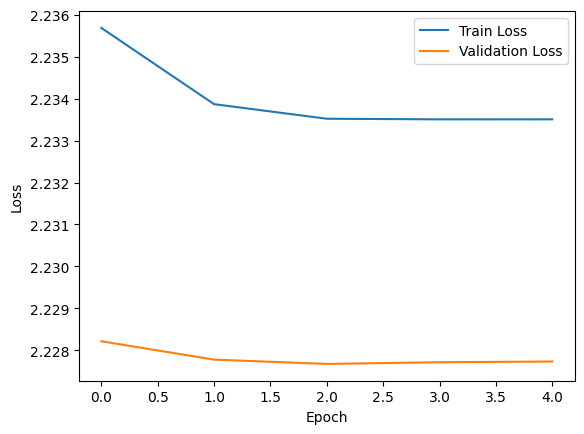

In [12]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Improved LeNet5

In [14]:
class ImprovedCNN(nn.Module):
    def __init__(self):
        super(ImprovedCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)  # same as LeNet-5
        self.bn1 = nn.BatchNorm2d(6) # improvement over LeNet-5
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.bn2 = nn.BatchNorm2d(16)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(120, 84)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

model2 = ImprovedCNN().to(device)

summary(model2, input_size=(1, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
       BatchNorm2d-2            [-1, 6, 28, 28]              12
            Conv2d-3           [-1, 16, 10, 10]           2,416
       BatchNorm2d-4           [-1, 16, 10, 10]              32
            Linear-5                  [-1, 120]          48,120
           Dropout-6                  [-1, 120]               0
            Linear-7                   [-1, 84]          10,164
           Dropout-8                   [-1, 84]               0
            Linear-9                   [-1, 10]             850
Total params: 61,750
Trainable params: 61,750
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.10
Params size (MB): 0.24
Estimated Total Size (MB): 0.34
---------------------------------------------

In [17]:
def test_model(model, dataloader, criterion, optimizer, device='cuda'):
    model.train()
    for imgs, lbls in dataloader:
        imgs, lbls = imgs.to(device), lbls.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, lbls)
        print("Forward OK. Loss:", loss.item())
        loss.backward()
        print("Backward OK.")
        optimizer.step()
        print("Optimizer step OK.")
        break  # only one batch
test_model(model2, trainloader, criterion, optimizer, device)

Forward OK. Loss: 2.3620314598083496
Backward OK.
Optimizer step OK.


## Training Improved LeNet5

In [20]:
# delete stuff from previous training and empty cache
# del optimizer, criterion, model, scheduler 
# torch.cuda.empty_cache()

# everything is same except model they are just re-instantiated

optimizer = torch.optim.Adam(model2.parameters(), lr=lr, betas=(0.9, 0.999), weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

scheduler = OneCycleLR(
    optimizer, 
    max_lr=lr*10,
    total_steps=num_epochs * len(trainloader),
    pct_start=0.3, 
    anneal_strategy='cos'
)

train_losses, val_losses, val_accuracies = train_model(model2, trainloader, testloader, criterion, optimizer, scheduler=scheduler, num_epochs=num_epochs)

Epoch [1/5], Step [400/469], Train Loss: 0.2048
Validation - Epoch [1/5], Test Loss: 0.0674, Test Accuracy: 97.90%
Epoch [1/5], Average Train Loss: 0.3197
Learning rate adjusted to: 0.004000
Epoch [2/5], Step [400/469], Train Loss: 0.2547
Validation - Epoch [2/5], Test Loss: 0.0592, Test Accuracy: 98.20%
Epoch [2/5], Average Train Loss: 0.1367
Learning rate adjusted to: 0.004002
Epoch [3/5], Step [400/469], Train Loss: 0.1209
Validation - Epoch [3/5], Test Loss: 0.0459, Test Accuracy: 98.58%
Epoch [3/5], Average Train Loss: 0.1107
Learning rate adjusted to: 0.004004
Epoch [4/5], Step [400/469], Train Loss: 0.0535
Validation - Epoch [4/5], Test Loss: 0.0423, Test Accuracy: 98.61%
Epoch [4/5], Average Train Loss: 0.0931
Learning rate adjusted to: 0.004008
Epoch [5/5], Step [400/469], Train Loss: 0.0444
Validation - Epoch [5/5], Test Loss: 0.0382, Test Accuracy: 98.81%
Epoch [5/5], Average Train Loss: 0.0883
Learning rate adjusted to: 0.004012


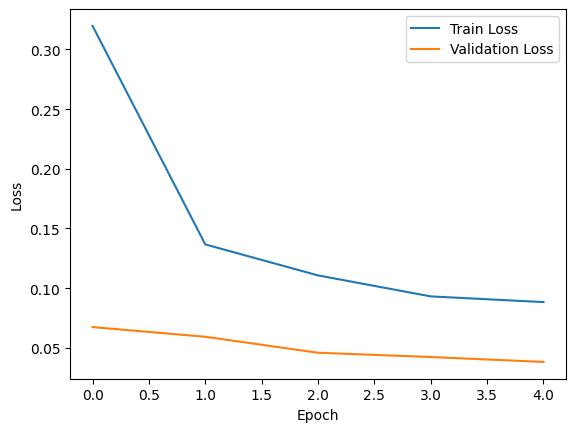

In [21]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## ResNet18

In [24]:
class MNISTResNet18(nn.Module):
    def __init__(self):
        super(MNISTResNet18, self).__init__()
        self.resnet = tv.models.resnet18(pretrained=False)
        # normally resnet18 excepts 3 input channel so we change it with 1
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, 10)

    def forward(self, x):
        return self.resnet(x)

In [25]:
resnet18 = MNISTResNet18().to(device)
summary(resnet18, input_size=(1, 32, 32))

c:\Users\baran\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\baran\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           3,136
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

## Training Resnet18

In [26]:
# delete stuff from previous training and empty cache
del optimizer, criterion, model2, scheduler 
torch.cuda.empty_cache()

# everything is same except model they are just re-instantiated

optimizer = torch.optim.Adam(resnet18.parameters(), lr=lr, betas=(0.9, 0.999), weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

scheduler = OneCycleLR(
    optimizer, 
    max_lr=lr*10,
    total_steps=num_epochs * len(trainloader),
    pct_start=0.3, 
    anneal_strategy='cos'
)

train_losses, val_losses, val_accuracies = train_model(resnet18, trainloader, testloader, criterion, optimizer, scheduler=scheduler, num_epochs=num_epochs)

Epoch [1/5], Step [400/469], Train Loss: 0.0526
Validation - Epoch [1/5], Test Loss: 0.0710, Test Accuracy: 97.84%
Epoch [1/5], Average Train Loss: 0.1404
Learning rate adjusted to: 0.004000
Epoch [2/5], Step [400/469], Train Loss: 0.1401
Validation - Epoch [2/5], Test Loss: 0.0448, Test Accuracy: 98.71%
Epoch [2/5], Average Train Loss: 0.0641
Learning rate adjusted to: 0.004002
Epoch [3/5], Step [400/469], Train Loss: 0.0207
Validation - Epoch [3/5], Test Loss: 0.0582, Test Accuracy: 98.18%
Epoch [3/5], Average Train Loss: 0.0565
Learning rate adjusted to: 0.004004
Epoch [4/5], Step [400/469], Train Loss: 0.0237
Validation - Epoch [4/5], Test Loss: 0.0584, Test Accuracy: 98.22%
Epoch [4/5], Average Train Loss: 0.0501
Learning rate adjusted to: 0.004008
Epoch [5/5], Step [400/469], Train Loss: 0.0160
Validation - Epoch [5/5], Test Loss: 0.0508, Test Accuracy: 98.33%
Epoch [5/5], Average Train Loss: 0.0497
Learning rate adjusted to: 0.004012


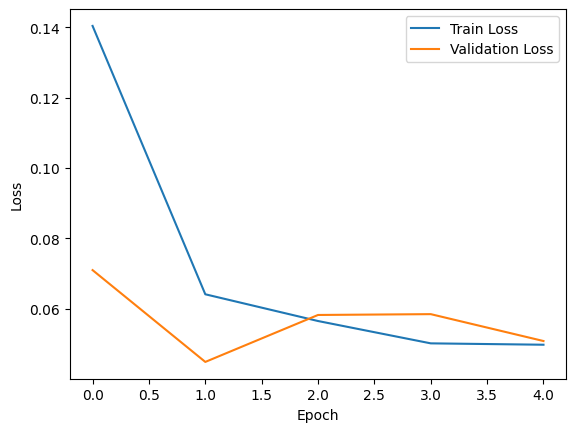

In [27]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Hybrid Model

In [ ]:
def extract_features(model, dataloader, features_file_name, labels_file_name, device ='cuda'):
    model.eval()
    features = []
    labels = []
    with torch.inference_mode():
        for imgs, lbls in dataloader:
            imgs = imgs.to(device)
            
            # get features by running forward pass and extracting before final layer
            if hasattr(model, 'fc2'):
                # for our custom CNN with fc2 (which is not preffered)
                x = imgs.view(imgs.size(0), -1)
                x = model.fc1(x)
                feats = model.fc2(x).detach().cpu().numpy()
            else:
                # for any model with a final fc layer (including ResNet)
                # get the model's modules as a list
                modules = list(model.children())
                # remove the last layer (classifier)
                feature_extractor = torch.nn.Sequential(*modules[:-1])
                # extract features
                x = feature_extractor(imgs)
                feats = x.reshape(x.size(0), -1).detach().cpu().numpy()
                
            features.append(feats)
            labels.append(lbls.numpy())
            
    features = np.concatenate(features)
    labels = np.concatenate(labels)
    np.save(features_file_name, features)
    np.save(labels_file_name, labels)
    print('Features and labels saved as .npy')
    return features, labels

In [44]:
X_train, y_train = extract_features(resnet18, trainloader, 'features_train.npy', 'labels_train.npy') # create train set for canonical ML model.

Features and labels saved as .npy


In [45]:
X_test, y_test = extract_features(resnet18, testloader, 'features_test.npy', 'labels_test.npy')

Features and labels saved as .npy


In [48]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

X_train = np.load('features_train.npy')
y_train = np.load('labels_train.npy')
X_test = np.load('features_test.npy')
y_test = np.load('labels_test.npy')

clf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Random Forest accuracy:', accuracy_score(y_test, y_pred))

Random Forest accuracy: 0.9702


# THE END